In [1]:
#adapted from http://mlbernauer.com/R/20160131-document-retrieval-sklearn.html

In [1]:
import os
import pandas as pd
import collections

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from gensim.summarization import summarize

from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics

# Configurations and Variable Definitions

In [64]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
DATA_FILE = '/data/pubmed_mesh_pain_english_4142016.txt'
#test variables
test_pmid = '27002445'

In [15]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

# Input File Processing

In [4]:
#Taken directly from reference:

In [27]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
def read_medline_data(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "authors", "affiliation", "grant",
                                   "abstract", "pubdate"])
    count = 0
    for rec in recs:
        try:
            abstr = rec["AB"]
            atitle = rec["TI"]
            auths = rec["AU"]
            pubdate = rec["DP"]
            jtitle = rec["JT"]
            grant=rec["GR"]
            pmid = rec['PMID']
            affil = rec['AD']
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle, auths, affil,grant, abstr,pubdate]],
                                     columns=["pmid", "articletitle", "journaltitle", "authors", "affiliation", 
                                              "grant", "abstract", "pubdate"]),ignore_index=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [28]:
# get the Data file path
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data(DATA_PATH)

CPU times: user 46.2 s, sys: 136 ms, total: 46.3 s
Wall time: 46.3 s


In [104]:
# Test
papers[papers.pmid == test_pmid]

,pmid,articletitle,journaltitle,authors,affiliation,grant,abstract,pubdate,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract
0,27002445,Effect of Mindfulness-Based Stress Reduction v...,JAMA,"[Cherkin DC, Sherman KJ, Balderson BH, Cook AJ...","Group Health Research Institute, Seattle, Wash...",[R01AT006226/AT/NCCIH NIH HHS/United States],IMPORTANCE: Mindfulness-based stress reduction...,2016 Mar 22-29,mindfulness-based stress reduction mbsr rigoro...,"[mindfulness, based, stress, reduction, mbsr, ...",IMPORTANCE#NUM Mindfulness-based stress reduct...,"[IMPORTANCE, Mindfulness, based, stress, reduc...",247,495,123



# Text Cleanup & Tokenization

## Remove "all-caps:", punctuation marks, numbers, ..

In [9]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, basestring):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('\s-\s', '', d))
    
    return abstracts, non_digit_filtered

## Remove stop words

In [10]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = string.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

## Convert to lower case, tokenize

In [11]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [12]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

## Preprocess using all above

In [13]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [14]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('\s-\s', '', d))
    return abstracts

## Apply preprocessing

In [68]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

In [69]:
#Test
print 'Original Abstract: \n', papers.abstract[papers.pmid == test_pmid][0]
print '\nProcessed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL][0]
print '\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL][0]
papers[(papers.pmid == test_pmid)]

Original Abstract: 
IMPORTANCE: Mindfulness-based stress reduction (MBSR) has not been rigorously evaluated for young and middle-aged adults with chronic low back pain. OBJECTIVE: To evaluate the effectiveness for chronic low back pain of MBSR vs cognitive behavioral therapy (CBT) or usual care. DESIGN, SETTING, AND PARTICIPANTS: Randomized, interviewer-blind, clinical trial in an integrated health care system in Washington State of 342 adults aged 20 to 70 years with chronic low back pain enrolled between September 2012 and April 2014 and randomly assigned to receive MBSR (n = 116), CBT (n = 113), or usual care (n = 113). INTERVENTIONS: CBT (training to change pain-related thoughts and behaviors) and MBSR (training in mindfulness meditation and yoga) were delivered in 8 weekly 2-hour groups. Usual care included whatever care participants received. MAIN OUTCOMES AND MEASURES: Coprimary outcomes were the percentages of participants with clinically meaningful (>/=30%) improvement from ba

,pmid,articletitle,journaltitle,authors,affiliation,grant,abstract,pubdate,cleaned_abstract,tokenized_c_abstract,cleaned_minimal_abstract,tokenized_r_abstract,token_count_c_abstract,token_count_r_abstract,token_count_unq_c_abstract
0,27002445,Effect of Mindfulness-Based Stress Reduction v...,JAMA,"[Cherkin DC, Sherman KJ, Balderson BH, Cook AJ...","Group Health Research Institute, Seattle, Wash...",[R01AT006226/AT/NCCIH NIH HHS/United States],IMPORTANCE: Mindfulness-based stress reduction...,2016 Mar 22-29,mindfulness-based stress reduction mbsr rigoro...,"[mindfulness, based, stress, reduction, mbsr, ...",IMPORTANCE#NUM Mindfulness-based stress reduct...,"[IMPORTANCE, Mindfulness, based, stress, reduc...",247,495,123


In [67]:
summarize(papers.loc[papers.pmid == test_pmid].abstract[0])

'DESIGN, SETTING, AND PARTICIPANTS: Randomized, interviewer-blind, clinical trial in an integrated health care system in Washington State of 342 adults aged 20 to 70 years with chronic low back pain enrolled between September 2012 and April 2014 and randomly assigned to receive MBSR (n = 116), CBT (n = 113), or usual care (n = 113).\nCONCLUSIONS AND RELEVANCE: Among adults with chronic low back pain, treatment with MBSR or CBT, compared with usual care, resulted in greater improvement in back pain and functional limitations at 26 weeks, with no significant differences in outcomes between MBSR and CBT.'

## Abstract Length Plots

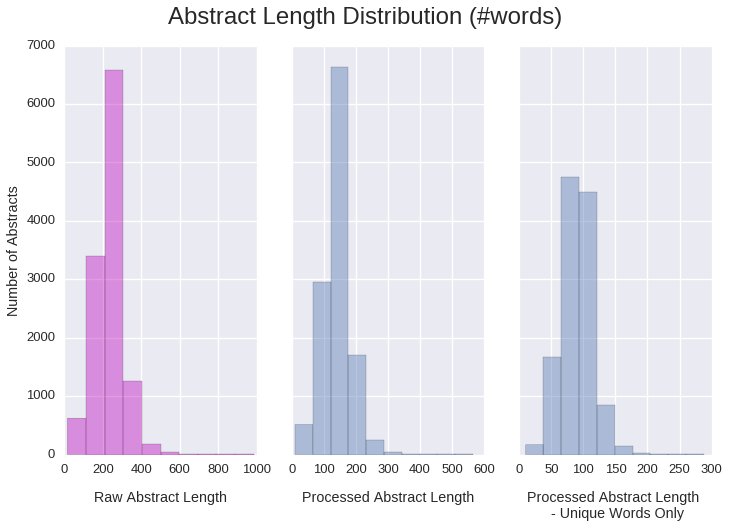

In [77]:
# And now, some figures
sns.set()
sns.set_context("talk")
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)

# First sub-figure: raw abstract token count
sns.distplot(papers[TOKEN_COUNT_RAW_ABS_COL], bins=10, kde=False, ax= ax1, color ='m')
ax1.set_xlabel('Raw Abstract Length', labelpad=15)
ax1.set_ylabel('Number of Abstracts')
# Second sub-figure: token count
sns.distplot(papers[TOKEN_COUNT_CLEAN_ABS_COL], bins=10, kde=False, ax= ax2)
ax2.set_xlabel('Processed Abstract Length', labelpad=15)
# Third sub-figure: unique token count
sns.distplot(papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL], bins=10, kde=False, ax = ax3)
ax3.set_xlabel('Processed Abstract Length \n - Unique Words Only', labelpad=15)

# set the main title
fig.suptitle("Abstract Length Distribution (#words)", fontsize = 24, y = 1.03)
plt.tight_layout()

# Identify the most common terms


In [70]:
# Word counts and such using CountVectorizer from https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
# see http://bit.ly/1U7TtRd
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

# set tokenizer = None for no stemming
cvec = CountVectorizer(analyzer = "word", tokenizer = tokenize, stop_words = 'english', max_features = 5000) 

In [71]:
#Identify the most common terms for each document via CountVectorizer
ca_tdm = pd.DataFrame(cvec.fit_transform(papers[CLEANED_ABSTRACT_COL]).toarray(),columns=cvec.get_feature_names())
sum_of_counts = ca_tdm.sum('rows').sort_values(ascending=False)

## Plot Word Frequency

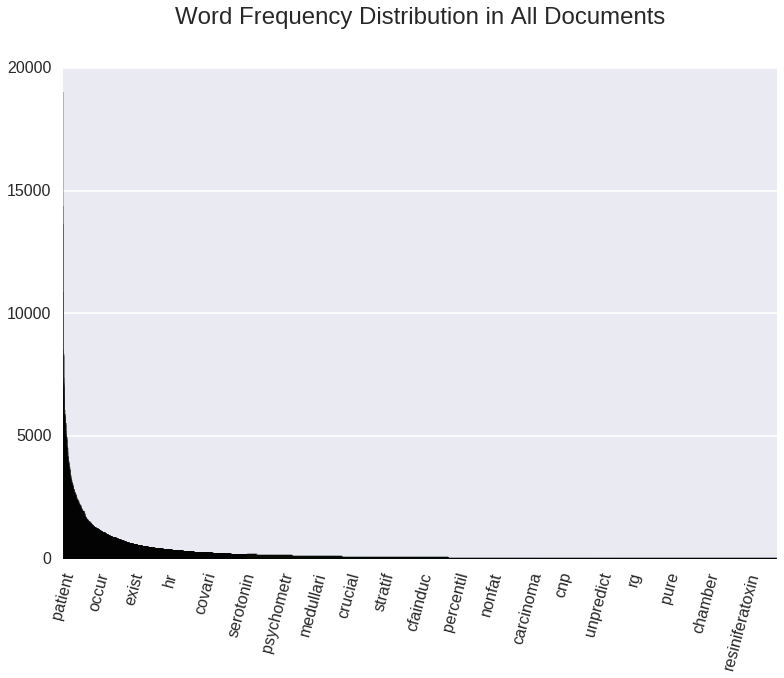

In [21]:
# configuration: num of ticks will set how mnay ticks (terms) will be shown on the x axis
NUM_OF_TICKS = 20
# by settings START > 0, it is possible to ignore the most frequent terms (e.g. pain)
# set START to 0 to start from the most frequent term
START = 1  

#start plotting
sns.set_context("poster")
g = sns.barplot(data = sum_of_counts.to_frame()[START:], x = sum_of_counts.keys()[START:], y = sum_of_counts.get_values()[START:])
plt.xticks(rotation = 75)

# change the number of items dispalyed on the x-axis, we don't want it to get cluttered
words_indices = range(START,(sum_of_counts.size - 1), (sum_of_counts.size / NUM_OF_TICKS))
if not (sum_of_counts.size -1) in words_indices:
    words_indices.append(sum_of_counts.size - 1)
labels = [''] * sum_of_counts.size
for i in words_indices:
    labels[i] = sum_of_counts.keys()[i]


# set the label and title
g.set_xticklabels(labels)
plt.axes().set_title('Word Frequency Distribution in All Documents', fontsize = 24, y = 1.08)

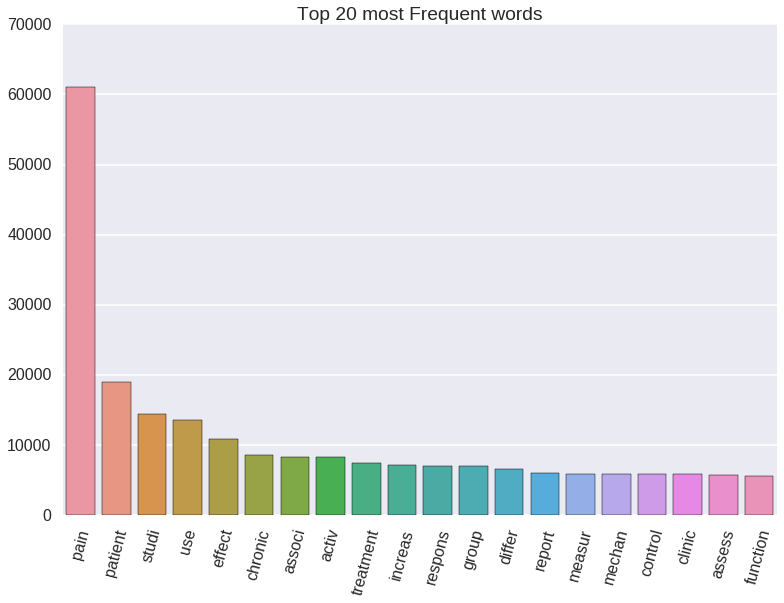

In [22]:
# Bar plot showing top n words
TOP = 20
sns.set_context("poster")
g = sns.barplot(data = sum_of_counts.to_frame()[0:TOP], x = sum_of_counts.keys()[0:TOP], y = sum_of_counts.get_values()[0:TOP])
plt.xticks(rotation = 75)
plt.axes().set_title('Top %d most Frequent words' % TOP)

# Create TF-IDF from Abstracts

In [72]:
tvec = TfidfVectorizer(analyzer='word',
                        max_features = 5000,
                        use_idf=True,
                        min_df=2,
                        max_df=0.5,
                        stop_words='english',
                        ngram_range=(1,3))

In [73]:
%time ca_tfidfm = tvec.fit_transform(papers[CLEANED_ABSTRACT_COL])
ca_tfidf_frame = pd.DataFrame(ca_tfidfm.toarray(),columns=tvec.get_feature_names())
print ('Shape of Cleaned Abstract TF-IDF Matrix: ',ca_tfidf_frame.shape)

CPU times: user 17.1 s, sys: 132 ms, total: 17.2 s
Wall time: 17.1 s
('Shape of Cleaned Abstract TF-IDF Matrix: ', (12117, 5000))


In [74]:
%time tfidf_dist = 1 - cosine_similarity(ca_tfidfm)

CPU times: user 5.88 s, sys: 164 ms, total: 6.04 s
Wall time: 6.03 s


/home/parisa/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/parisa/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


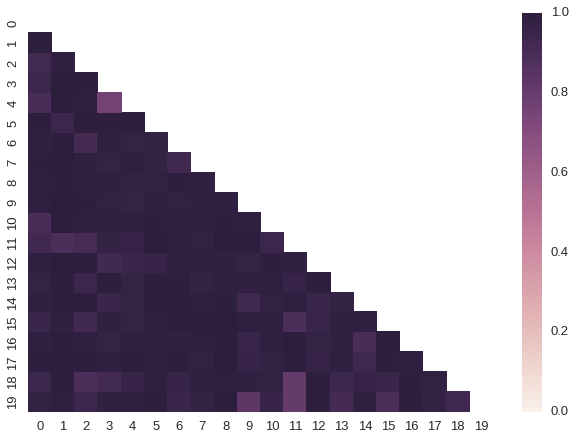

In [78]:
sub_sample_dist = tfidf_dist[0:20, 0:20]

# Use a mask to mask the upper half
mask = np.zeros_like(sub_sample_dist)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(sub_sample_dist, vmin=0, vmax=1, mask = mask)

# Cluster Abstracts

## Find k the number of clusters
[1] Original Paper http://web.stanford.edu/~hastie/Papers/gap.pdf

In [79]:
print("Performing dimensionality reduction using LSA")

svd = TruncatedSVD(1000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

%time reduced_tfidf = lsa.fit_transform(ca_tfidf_frame)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


Performing dimensionality reduction using LSA
CPU times: user 1min 30s, sys: 384 ms, total: 1min 30s
Wall time: 25.9 s
Explained variance of the SVD step: 66%


In [ ]:
# reduced_tfidf can be used instead of ca_tfidf_frame
%time ks, logWks, logWkbs, sk = GapStatistics.gap_statistic(ca_tfidf_frame.as_matrix())

In [51]:
cluster_analysis_frame = pd.DataFrame(data = logWks,index = ks, columns = ['logWks'])
cluster_analysis_frame['logWkbs'] = logWkbs
cluster_analysis_frame['sk'] = sk
gap = [logWkbs[i]-logWks[i] for i in range(len(ks))]
cluster_analysis_frame['gap'] = gap
final = [gap[i] - (gap[i+1] - sk[i+1]) for i in range(len(ks)-1)]
final.append(0)
cluster_analysis_frame['final'] = final
cluster_analysis_frame

,logWks,logWkbs,sk,gap,final
1,0.166974,5.122531,0.007875,4.955557,0.492383
2,0.156442,4.659702,0.040086,4.503260,0.482722
3,0.152651,4.180282,0.007093,4.027630,0.450635
4,0.149565,3.732075,0.005514,3.582509,0.174073
5,0.145382,3.566934,0.013116,3.421552,0.172239
6,0.141708,3.401255,0.010233,3.259546,0.175076
7,0.138911,3.235958,0.012577,3.097047,0.174903
8,0.136880,3.067210,0.008187,2.930330,0.162502
9,0.134373,2.928543,0.026341,2.794169,0.000000


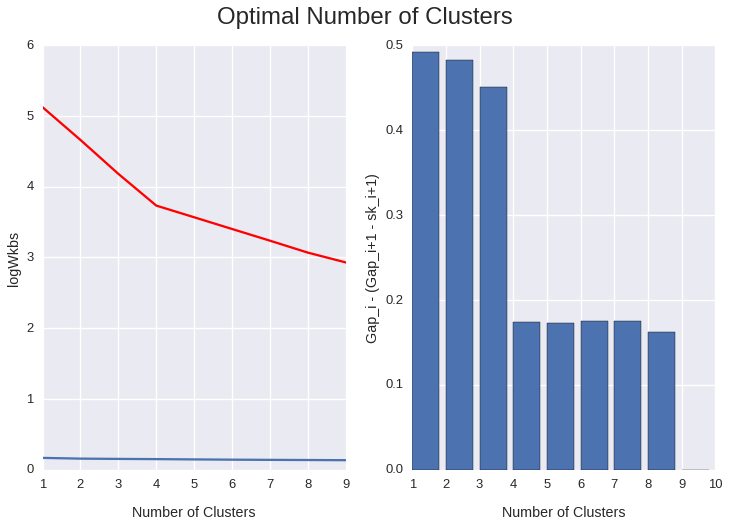

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

# First sub-figure: raw abstract token count
ax1.plot(ks, logWks)
ax1.set_xlabel('Number of Clusters', labelpad=15)
ax1.set_ylabel('logWks')
# Second sub-figure: token count
ax1.plot(ks, logWkbs, color = 'r')
ax1.set_xlabel('Number of Clusters', labelpad=15)
ax1.set_ylabel('logWkbs')
# Third sub-figure: unique token count
ax2.bar(ks, final)
ax2.set_xlabel('Number of Clusters', labelpad=15)
ax2.set_ylabel('Gap_i - (Gap_i+1 - sk_i+1)')

# set the main title
fig.suptitle("Optimal Number of Clusters", fontsize = 24, y = 1.03)
plt.tight_layout()

## Cluster

In [36]:
# Build the clusters
num_clusters = 5
km = KMeans(n_clusters=num_clusters, init='k-means++')

%time km.fit(reduced_tfidf)

clusters = km.labels_.tolist()

CPU times: user 1min 5s, sys: 1.36 s, total: 1min 7s
Wall time: 33.8 s


In [37]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Silhouette Coefficient: 0.010


In [38]:
# Number of items in each cluster
counts = [clusters.count(i) for i in range(num_clusters)]
counts

[2153, 609, 2739, 4785, 1831]

In [39]:
# This will get the most common words in each cluster
# get the index of each data point in cluster i in its original dataset
clabel_data = {i: np.where(km.labels_ == i)[0] for i in range(num_clusters)}
# get the data points from their indices in the count dataset
clabel_count = {i: ca_tdm.loc[clabel_data[i].tolist()] for i in range(num_clusters)}
# sum the counts of each word in each cluster
sum_of_counts_in_cluster = {i: clabel_count[i].sum().sort_values(ascending=False) for i in range(num_clusters)}
#print out the most frequent words in each clusters
for i in range(num_clusters):
    print '\n Top words in cluster %d \n' %i , sum_of_counts_in_cluster[i][0:10]


 Top words in cluster 0 
pain        5437
effect      4110
receptor    3232
rat         2832
respons     2459
morphin     2206
studi       2058
activ       2035
mechan      1788
produc      1747
dtype: int64

 Top words in cluster 1 
patient     2933
coronari    1351
angina      1341
pain        1063
chest        945
myocardi     724
risk         693
studi        631
acut         580
use          576
dtype: int64

 Top words in cluster 2 
pain         16678
patient      10369
use           5290
treatment     4059
studi         4052
opioid        2997
group         2853
care          2846
effect        2694
chronic       2505
dtype: int64

 Top words in cluster 3 
pain        31203
studi        6191
associ       5271
use          5064
patient      4914
chronic      3864
symptom      3481
report       3411
measur       3245
function     3146
dtype: int64

 Top words in cluster 4 
pain         6626
neuron       3839
spinal       3380
nerv         2761
mechan       2584
activ        2417


 *How do we extract the most common terms from each cluster?
 
 >See my code above, not sure if this is what you itended?

## GenSim for LDA, Topic Modeling, word2vec

adapted from http://www.datasciencebytes.com/bytes/2014/12/30/topic-modeling-of-shakespeare-characters/

## Topic Modeling via LSI/LDA

In [80]:
num_of_topics = 3
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [81]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

In [82]:
%time lsi = models.lsimodel.LsiModel(ca_gs_corpus, id2word=ca_gs_dictionary, num_topics=num_of_topics)
lsi.save('ca_gs.lsi')

CPU times: user 5.26 s, sys: 88 ms, total: 5.35 s
Wall time: 1.99 s


In [83]:
for i, topic in enumerate(lsi.print_topics(num_of_topics)):
    print 'Topic %d:' %i
    print topic
    print 

Topic 0:
(0, u'0.451*"patients" + 0.194*"study" + 0.181*"chronic" + 0.154*"treatment" + 0.129*"associated" + 0.107*"may" + 0.105*"group" + 0.103*"opioid" + 0.102*"care" + 0.101*"related"')

Topic 1:
(1, u'-0.452*"patients" + 0.275*"spinal" + 0.209*"rats" + 0.192*"neurons" + 0.171*"induced" + 0.156*"nerve" + 0.149*"receptor" + 0.132*"injury" + 0.128*"mechanical" + 0.124*"neuropathic"')

Topic 2:
(2, u'-0.677*"patients" + 0.180*"women" + 0.149*"back" + 0.133*"participants" + 0.132*"associated" + 0.130*"chronic" + 0.124*"health" + 0.121*"study" + 0.116*"reported" + -0.115*"spinal"')



In [ ]:
%time lda = models.LdaModel(ca_gs_corpus, num_topics=num_of_topics, id2word =ca_gs_dictionary, update_every=5, passes=100)

In [101]:
lda.save("./data/model.lda")
lda.print_topics(num_of_topics)

[(0,
  u'0.010*neurons + 0.008*spinal + 0.007*nerve + 0.006*injury + 0.006*mechanical + 0.005*neuropathic + 0.005*stimulation + 0.005*dorsal + 0.005*stimuli + 0.005*rats'),
 (1,
  u'0.020*patients + 0.007*study + 0.005*chronic + 0.005*back + 0.005*treatment + 0.005*associated + 0.004*care + 0.004*reported + 0.004*clinical + 0.004*use'),
 (2,
  u'0.012*morphine + 0.011*effects + 0.010*opioid + 0.008*effect + 0.008*dose + 0.008*rats + 0.007*induced + 0.007*receptor + 0.006*analgesia + 0.006*administration')]

In [102]:
def get_lda_tokens(list):
    token_list = []
    for i in range(len(list)):
        token_list.append(ca_gs_dictionary.id2token[list[i][0]])
    return token_list

# get top 20 term ids in each LDA topic
top_lda_terms_n = 1000
top_lda_terms = {i: get_lda_tokens(lda.get_topic_terms(i, topn = top_lda_terms_n)) for i in range(num_of_topics)}

In [103]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, ca_gs_corpus, ca_gs_dictionary, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      56.759468        1       1  103.351472  108.191663
0      28.525979        1       2 -321.416350 -135.839873
2      14.714553        1       3 -176.028336 -336.358667, topic_info=      Category          Freq             Term         Total  loglift  logprob
term                                                                         
34701  Default  19137.000000         patients  19137.000000  30.0000  30.0000
12449  Default   2995.000000         morphine   2995.000000  29.0000  29.0000
17375  Default   4520.000000          neurons   4520.000000  28.0000  28.0000
11025  Default   3427.000000           opioid   3427.000000  27.0000  27.0000
138    Default   4691.000000          effects   4691.000000  26.0000  26.0000
13966  Default   3532.000000            nerve   3532.000000  25.0000  25.0000
20179  Default   5566.000000           spinal   5566.000000  24.0000  24.0000
17028  Default   4173.000000             rats   4173.000000  23.0000  23.0000
22626  Default   2069.000000             dose   2069.000000  22.0000  22.0000
31844  Default   3512.000000           effect   3512.000000  21.0000  21.0000
31827  Default   3709.000000          induced   3709.000000  20.0000  20.0000
31914  Default   2740.000000         receptor   2740.000000  19.0000  19.0000
15493  Default   2463.000000           dorsal   2463.000000  18.0000  18.0000
15992  Default   1702.000000        analgesia   1702.000000  17.0000  17.0000
12392  Default   3091.000000           injury   3091.000000  16.0000  16.0000
29280  Default   2173.000000         produced   2173.000000  15.0000  15.0000
34180  Default   1804.000000   administration   1804.000000  14.0000  14.0000
15086  Default   4944.000000             back   4944.000000  13.0000  13.0000
7962   Default   2599.000000      neuropathic   2599.000000  12.0000  12.0000
20109  Default   2791.000000       mechanical   2791.000000  11.0000  11.0000
31937  Default   2252.000000            cells   2252.000000  10.0000  10.0000
16625  Default   3096.000000      stimulation   3096.000000   9.0000   9.0000
15991  Default   1853.000000        analgesic   1853.000000   8.0000   8.0000
32422  Default   2501.000000          stimuli   2501.000000   7.0000   7.0000
9740   Default   2854.000000      nociceptive   2854.000000   6.0000   6.0000
33292  Default   3408.000000         response   3408.000000   5.0000   5.0000
21229  Default   4091.000000             care   4091.000000   4.0000   4.0000
32256  Default   2569.000000     hyperalgesia   2569.000000   3.0000   3.0000
3830   Default   2003.000000        injection   2003.000000   2.0000   2.0000
2713   Default   1123.000000  antinociception   1123.000000   1.0000   1.0000
...        ...           ...              ...           ...      ...      ...
23136   Topic3    633.712855          agonist    661.336902   1.8737  -5.9568
15992   Topic3   1535.824060        analgesia   1702.134575   1.8135  -5.0716
26785   Topic3    628.467029            delta    682.481129   1.8339  -5.9651
1949    Topic3   1010.075144       antagonist   1135.792556   1.7990  -5.4906
34180   Topic3   1504.472664   administration   1804.204358   1.7347  -5.0922
14019   Topic3    439.102360         infusion    474.554509   1.8387  -6.3237
34996   Topic3    328.418079            water    346.184017   1.8637  -6.6141
3762    Topic3    978.983845      intrathecal   1158.114559   1.7483  -5.5219
11025   Topic3   2560.140944           opioid   3427.428214   1.6246  -4.5606
19369   Topic3    508.753977      antagonists    572.303929   1.7986  -6.1765
24788   Topic3    856.273300              min   1051.257461   1.7112  -5.6558
29280   Topic3   1485.710084         produced   2173.258187   1.5360  -5.1048
32327   Topic3    744.106274        tolerance    946.125531   1.6761  -5.7962
138     Topic3   2615.192410          effects   4691.294238   1.3320  -4.5393
1

## Word2Vec

In [49]:
texts_cleaned = filter(None, [next_text.strip(' ').split(' ') for next_text in papers[CLEANED_MINIMAL_ABSTRACT_COL]])
w2vmodel = gensim.models.Word2Vec(texts_cleaned, size=300, window=5, min_count=5, workers=4)
w2vmodel.save('w2v_stemmed_model_4_14_Pain_MESH_cleanedabstracts')

In [50]:
# Basic Similarity Testing

print 'Most similar to pain:', w2vmodel.most_similar('pain'); print ('')
print 'Most similar to acute:', w2vmodel.most_similar('acute'); print ('')
print 'Most similar to chronic:', w2vmodel.most_similar('chronic')
print ('')
print ('')
print 'Most similar between pain - chronic:', w2vmodel.most_similar(positive=['pain'], negative=['chronic']); print ('')
print 'Most similar between pain - acute:', w2vmodel.most_similar(positive=['pain'], negative=['acute']);print ('')
print ('')
print 'Most similar between acute and chronic:', w2vmodel.most_similar(positive=['acute'], negative=['chronic']);print ('')
print 'Most similar between chronic and acute:', w2vmodel.most_similar(positive=['chronic'], negative=['acute']);print ('')
print ('')
print 'Calculated similarity between acute and chronic:', w2vmodel.similarity('acute', 'chronic');print ('')
print 'Calculated similarity between anesthesia and surgery:', w2vmodel.similarity('anesthesia', 'surgery');print ('')

Most similar to pain: [('pain#NUM', 0.764876127243042), ('symptom', 0.6559004187583923), ('pain-related', 0.6327235698699951), ('discomfort', 0.6127642393112183), ('illness', 0.5317280292510986), ('Pain', 0.518229067325592), ('headache', 0.5076656341552734), ('anxiety', 0.5059146285057068), ('fatigue', 0.5056077241897583), ('LBP', 0.4907272756099701)]

Most similar to acute: [('chest', 0.606712818145752), ('persistent', 0.5895514488220215), ('syndromes', 0.5866013765335083), ('ischemic', 0.5833892822265625), ('inflammatory', 0.578711986541748), ('ongoing', 0.5524437427520752), ('early', 0.5449695587158203), ('chronic#NUM', 0.5437923669815063), ('ischemia', 0.5405331254005432), ('postsurgical', 0.5367621183395386)]

Most similar to chronic: [('persistent', 0.7826836109161377), ('neuropathic', 0.644494891166687), ('musculoskeletal', 0.6308231353759766), ('cancer', 0.6212172508239746), ('low-back', 0.6185286641120911), ('arthritis', 0.6152593493461609), ('chronic#NUM', 0.5957678556442261)

In [53]:
def getWordVecs(words):
    vecs = []
    for word in words:
        word = word.replace('\n', '')
        try:
            vecs.append(w2vmodel[word].reshape((1,300)))
        except KeyError:
            continue
    vecs = np.concatenate(vecs)
    return np.array(vecs, dtype='float') #TSNE expects float type values


# From https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis

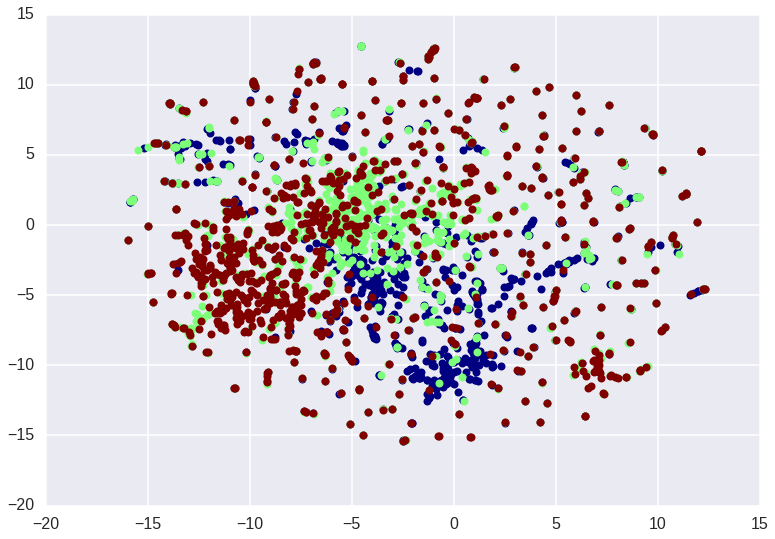

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# get the word vector representation of the top terms in each LDA topic
word_vecs = getWordVecs(top_lda_terms[0])
for i in range(1, len(top_lda_terms)):    
    word_vecs = np.concatenate([word_vecs,getWordVecs(top_lda_terms[i])])

ts = TSNE(2)
reduced_vecs = ts.fit_transform(word_vecs)

#color points by word group to see if Word2Vec can separate them
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, num_of_topics))

for i in range(len(reduced_vecs)):
    color = colors[(i* num_of_topics) /len(reduced_vecs)]
    plt.plot(reduced_vecs[i,0], reduced_vecs[i,1], marker='o', color=color, markersize=8)